In [378]:
import scipy as sp
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import theano 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import initializers
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras import regularizers
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline
import notebooks.myutil_gru_class as myutil

In [379]:
import importlib
_ = importlib.reload(myutil)

## Get data and do preliminary preprocessing

In [380]:
dfx_train = myutil.get_indexed_dataset('data/dengue_features_train.csv')
dfy_train = myutil.get_indexed_dataset('data/dengue_labels_train.csv')
dfx_test = myutil.get_indexed_dataset('data/dengue_features_test.csv')
# combine training features with training labels for data exploration later on
dftrain = myutil.set_index(pd.merge(dfx_train, dfy_train))
# Will stack the train and test datasets to treat all NaN values together
# Need to add bogus total_cases column to test dataset so the files can be easily concatenated
# update total_cases = -1 to easily identify the records for later split data to original partitions
dfx_test['total_cases'] = -1
dfall = myutil.set_index(pd.concat((dftrain, dfx_test), axis=0))
dfall.sort_index(axis=0, inplace=True)
# drop unecessary columns and save column names
delcols = ['year','week_start_date','reanalysis_sat_precip_amt_mm','reanalysis_specific_humidity_g_per_kg']
dfall.drop(delcols, axis=1, inplace=True)
cols = dfall.columns
# remove NaNs
dfall = myutil.set_nan_to_week_mean(dfall.copy())

### Slip dataset by city and One hot encode city and weekofyear +
### Create several versions of the datasets (total cases is NOT feature) +
### Switch to Classification Problem

In [381]:
# split dataset and hot encode weekof year
dfall_copy = dfall.copy()
dfall_iq = dfall_copy[dfall_copy['city'] == 'iq']
dfall_sj = dfall_copy[dfall_copy['city'] == 'sj']
enc = OneHotEncoder(categorical_features=np.array([0]))
dset = dict()
dset['iq'] = enc.fit_transform(dfall_iq.iloc[:,1:].values).toarray()
dset['sj'] = enc.fit_transform(dfall_sj.iloc[:,1:].values).toarray()

# for each city, create version of datasets with 1, 2, 4, 8, 12 shifts
for city in dset.keys():
    datashift = dict()
    for shift_no in [1,2,4,8,12]:
        #datashift[shift_no] = myutil.shift(np.hstack((dset[city],dset[city][:,-1:])), shift_no)
        datashift[shift_no] = myutil.shift(dset[city], shift_no)
    dset[city] = datashift

# for each city, each shift, create version of the dataset different scaling
for city in dset.keys():
    for shift_no in dset[city].keys():
        vers = dict()
        # save original as 'raw'
#        vers['raw'] = np.hstack((dset[city][shift_no][:,:-1], dset[city][shift_no][:,-1:]))
        # save scaled with minmax in range [0,1] as 'minmax1'
        scaler = MinMaxScaler(feature_range=(0,1))
#        vers['minmax1'] = np.hstack((scaler.fit_transform(dset[city][shift_no][:,:-1]), dset[city][shift_no][:,-1:]))
        # save scaled with minmax in range [0,1] as 'minmax1'
        # isolate features, so scaling will only affect features
        scaler = MinMaxScaler(feature_range=(-1,1))
        vers['minmax2'] = np.hstack((scaler.fit_transform(dset[city][shift_no][:,:-1]), dset[city][shift_no][:,-1:]))
        dset[city][shift_no] = vers
        
# for each city, each shift, each version, create X_train, y_train, and X_test partitions
dataset = dict()
for city in dset.keys():
    for shift_no in dset[city].keys():
        for vers in dset[city][shift_no].keys():
            npdata = dset[city][shift_no][vers]
            partition = dict()
            partition['X_train'] = npdata[npdata[:,-1]>0][:,:-1]
            partition['y_train'] = npdata[npdata[:,-1]>0][:,-1:]
            partition['X_test']  = npdata[npdata[:,-1]<0][:,:-1]
            id = city + '_' + str(shift_no).zfill(2) + '_' + vers
            dataset[id] = partition

#----------------------------------------------------------------------------------------------------
# Switch to classification problem

def get_class_from_value(total_cases, actual_to_class):   
    cls = 1
    for interval in actual_to_class.keys():
        if total_cases in interval:
            cls = actual_to_class[interval]
    #print(actual_to_class)
    #print('got {}, will return {}'.format(total_cases, cls))
    return int(cls)
   
def get_value_from_class(source_class, class_to_actual): 
    val = 1
    for cls in class_to_actual.keys():
        if source_class == cls:
            val = np.floor(class_to_actual[cls].mid)
    return val

def get_class_mapping(x, bins):
    
    y = pd.cut(x, precision=0, bins=bins)
    
    class_to_actual = dict()
    actual_to_class = dict()
    i = 0
    for interval in y.categories:
        class_to_actual[i] = interval
        actual_to_class[interval] = int(i)
        i += 1
        
    return class_to_actual, actual_to_class

classes = 10

# y values are the same for all datasets (for each city)
regr_value_iq = np.copy(dataset['iq_01_minmax2']['y_train'])
regr_value_sj = np.copy(dataset['sj_01_minmax2']['y_train'])
class_value_iq = np.copy(regr_value_iq)
class_value_sj = np.copy(regr_value_sj)

# set class mapping dictionaries
class_to_regr_iq = dict()
regr_to_class_iq = dict()
class_to_regr_sj = dict()
regr_to_class_sj = dict()
class_to_regr_iq, regr_to_class_iq = get_class_mapping(np.copy(regr_value_iq).reshape(-1), classes)
class_to_regr_sj, regr_to_class_sj = get_class_mapping(np.copy(regr_value_sj).reshape(-1), classes)

# convert regr to class for iq
i = 0
for regr in list(regr_value_iq):
    class_value_iq[i] = get_class_from_value(regr, regr_to_class_iq)
    i += 1
    
# convert regr to class for sj
i = 0
for regr in list(regr_value_sj):
    class_value_sj[i] = get_class_from_value(regr, regr_to_class_sj)
    i += 1
    
for key in dataset.keys():
    #print(key)
    if key[:2] == 'iq':
        dataset[key]['y_train'] = np.copy(class_value_iq[-dataset[key]['X_train'].shape[0]:,:])
    else:
        dataset[key]['y_train'] = np.copy(class_value_sj[-dataset[key]['X_train'].shape[0]:,:])
        
#np.hstack((dataset['sj_02_minmax2']['y_train'], regr_value_sj))

In [382]:
#for key in dataset.keys():
#    print(key)

#dataset['iq_1_minmax2']['y_train'][0]

In [383]:
def GRU_run(X, y, timesteps, reg, classes, epochs=50, batch_size=32, exploring=False):
    
    # create partitions for training
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30)
    if exploring: print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

    X_train = X_train.reshape(X_train.shape[0], timesteps, int(X_train.shape[1]/timesteps))
    X_valid = X_valid.reshape(X_valid.shape[0], timesteps, int(X_valid.shape[1]/timesteps)) 
    
    data_dim = X_train.shape[2]

    # build graph
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(GRU(X_train.shape[2], return_sequences=True, input_shape=(timesteps, X_train.shape[2])))  
    model.add(GRU(X_train.shape[2], return_sequences=True))    
    model.add(GRU(classes))                           
    model.add(Dense(classes, activation='softmax', kernel_regularizer=regularizers.l2(reg)))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    #model.summary()

    # fit net
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
    
    y_hat  = np.argmax(model.predict(X_train), axis=1)
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    
    y_train.shape = y_hat.shape
    y_train = y_train.astype('int')
    print("y_train", y_train)
    print("y_hat", y_hat)
    
    y_valid.shape = y_pred.shape
    y_valid = y_valid.astype('int')
    print("y_valid", y_valid)
    print("y_pred", y_pred)
    
    acc_train = accuracy_score(y_train.astype('str'), y_hat.astype('str'))
    acc_valid = accuracy_score(y_valid.astype('str'), y_pred.astype('str'))
    r2        = r2_score(y_valid, y_pred)
    print('Accurary train: {}'.format(acc_train))
    print('Accurary valid: {}'.format(acc_valid))
    print('R2 score      : {}'.format(r2))

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    
    if exploring:
        print("Final loss train: {}".format(history.history['loss'][-1]))
        print("Final loss valid: {}".format(history.history['val_loss'][-1]))

    plt.legend()
    plt.show()
    
    return model

# Get test dataset, create predictions and save them in the proper submission file format
def GRU_predict_and_save(df_iq, model_iq, df_sj, model_sj, dftest_iq, dftest_sj, filename):

    yhat_iq = model_iq.predict(nptest_iq.reshape(nptest_iq.shape[0], ts_iq, int(nptest_iq.shape[1]/ts_iq)))
    yhat_sj = model_sj.predict(nptest_sj.reshape(nptest_sj.shape[0], ts_sj, int(nptest_sj.shape[1]/ts_sj)))
    
    print(yhat_iq.shape)
    print(yhat_sj.shape)

    dfsubm = pd.read_csv('data/submission_format.csv')
    npsubm_sj = np.concatenate((dfsubm[dfsubm['city']=='sj'][['city','year','weekofyear']].values, \
                                yhat_sj.round().astype('int64')), axis=1)
    npsubm_iq = np.concatenate((dfsubm[dfsubm['city']=='iq'][['city','year','weekofyear']].values, \
                                yhat_iq.round().astype('int64')), axis=1)
    dfresults = pd.DataFrame(np.concatenate((npsubm_sj, npsubm_iq), axis=0), columns=dfsubm.columns)
    dfresults.to_csv(filename, index=False)
    

iq_01_minmax2

(296, 71) (128, 71) (296, 1) (128, 1)
y_train [1 0 0 0 1 2 2 1 2 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 0 1 1 0 0 1 0 0
 1 1 0 0 1 0 2 0 0 0 2 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 3 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0
 0 2 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 5 0 0 0 0 3 0 0 0 1 0 1 1 0 0 0 0 0
 0 3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0
 2 1 0 0 2 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 1 2 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0
 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 2 0 2 0 2 0 0 2 0 0 0 0 0 0 1 0 0 0]
y_hat [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

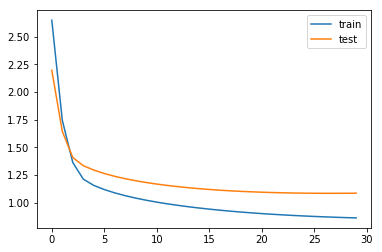

iq_02_minmax2

(296, 142) (128, 142) (296, 1) (128, 1)
y_train [0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 2 0 0 2 0 0
 0 0 0 0 0 0 2 0 3 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 2 0 1
 0 2 0 0 0 0 0 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0
 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 2 1 1 0 2 1 0 1 0 2
 0 4 0 0 0 1 0 2 0 1 1 1 0 0 0 0 1 5 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 4 1 0 2 0 1 0 1 0 0 0 3 0 2 0 0 2 0 1 1 0 0 1 0 0 1 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 2 0 3 1 1 0 0 1 1 0 0 1
 0 0 0 1 0 1 0 1 1 0 2 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 2 7 0 0 0 0 0 0 0 0 2]
y_hat [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

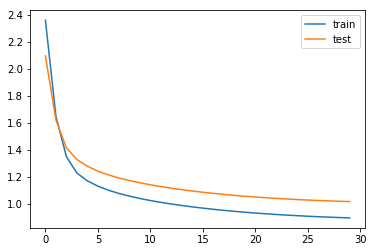

iq_04_minmax2

(296, 284) (128, 284) (296, 1) (128, 1)
y_train [0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 3 0 0 2 0 0 0 0 1 0 0 2 0 1 0 1 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 2 0 2 1 0 0 1 1 0 0 0 0 1 0 0
 0 1 0 0 1 1 4 1 0 0 0 0 1 0 2 0 0 0 0 5 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 2 0 0 0 0 1 0 1 0 9 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 7 2 0 1 0 0 0
 0 0 2 0 1 0 0 0 1 0 0 0 0 0 0 1 0 2 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 3 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 1 3 0 1 1 0 0 0 0 0 0 0 0 0 1 2 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 1 0 1 0 0 0 3 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 3 1 0 0 2 0 0 0 0 2 0 0]
y_hat [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

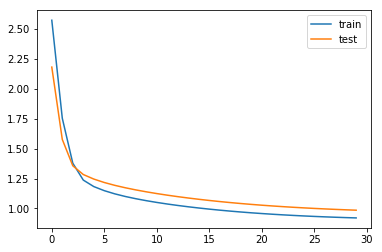

iq_08_minmax2

(296, 568) (128, 568) (296, 1) (128, 1)
y_train [0 2 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 2 2 0 0
 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 9 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 2 1 1 0 3 0 3 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 2 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 2 0 0 2 0 1 1 0 0 1 2 0 0 2 0 0 1 1
 3 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 3 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 2 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 1 0 5 0 1 0 0 0 0 0 0 0 3 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 3 0 0 1 0 2 1
 0 0 2 1 1 0 0 0 0 0 2 1 0 1 0 0 0 0 0 0 0 2 1 0 2 0 2 0 0 0 1 0 1 0 0 1 1]
y_hat [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

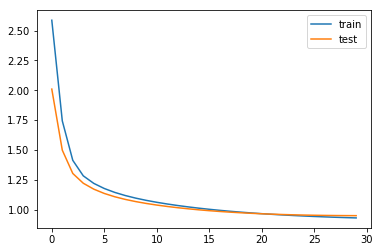

iq_12_minmax2

(296, 852) (127, 852) (296, 1) (127, 1)
y_train [0 0 0 0 0 0 2 0 0 0 0 2 4 0 1 0 0 0 0 0 3 0 2 0 0 1 2 1 0 0 0 1 0 0 0 0 0
 0 0 2 0 1 0 2 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 2 0 0 0 0 1 1 3 0 0 1 2 0 0 1
 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 2 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 2 0 0 0 0 0 0 0 1 0 1 1 0 0 2 0 1 1 0 0 0 1 0 0 0 0 0 2 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 2 0 1 0 0 1 2 1 4 0 0 0 0 0 1 2 1
 0 0 1 0 2 7 0 0 0 2 0 0 0 0 1 1 0 0 0 0 1 0 0 3 0 2 0 0 0 1 2 1 0 0 0 0 0
 1 0 0 2 0 0 3 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 5 0 0 1]
y_hat [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

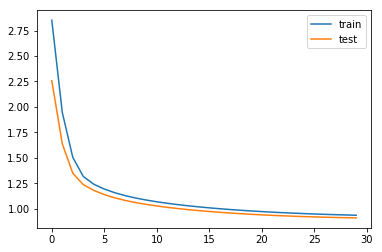

sj_01_minmax2

(651, 71) (280, 71) (651, 1) (280, 1)
y_train [0 1 0 1 0 0 0 0 2 0 0 1 0 0 0 2 0 0 0 0 0 0 1 1 0 0 0 0 1 2 0 1 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 0 3 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 1 1 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 2 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 1 0 0 0 0 0 3 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 1 1 1 0 0 0 2 0 1 0 0 0
 0 0 0 0 0 0 0 2 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 8 0 3 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 7 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 3 0 0 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 3 3 1 0
 0 0 0 0 0 1 5 0 1 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 1
 0 0 0 0 2 0 0 0 0 1 5 0 1 0 0 0 0 2 0 

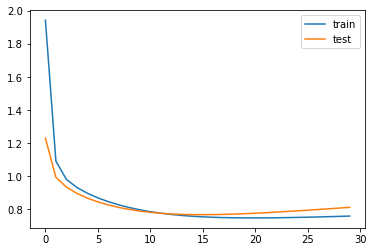

sj_02_minmax2

(651, 142) (279, 142) (651, 1) (279, 1)
y_train [0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 2 2 1 0 3 6 0 1 1 0 0 0 0 1 0 0 0 0 0 8 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 2 0 0 0 0 1 0
 0 0 0 3 0 0 0 4 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 1 0 5 3 0 0 1 0 2 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0
 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 2 0 0 0 0 0 2 1 0 0 0 1 1 1 7 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 5 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 2 0 0 0 1 0 0 0 3 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 1 0 4 0 0 1 0 1 0
 1 1 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0
 0 0 1 1 7 0 0 0 0 0 1 0 1 0 0 0 4 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 3 0 0 0 2 1 0 0 0 0 0 

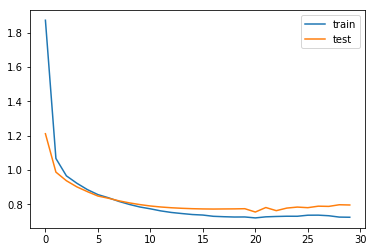

sj_04_minmax2

(649, 284) (279, 284) (649, 1) (279, 1)
y_train [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 8 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 8 0 2 4 0 1 0 0 0 0 1 0 0 2 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0 2 2 0 3 9 0 0
 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 6 0 0
 2 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 1 0 0 1 5 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 1 0 1 0 1 0 0 4 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 9 0 0 0 0 0 0 0 1 0 4 0 0 0 0 0
 0 1 0 0 0 0 0 2 0 0 3 0 0 0 1 0 0 0 0 3 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 4
 0 0 0 1 0 0 2 0 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1
 0 0 0 0 0 7 2 0 0 0 0 0 2 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 2 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 1 4 0 2 3 0 0 

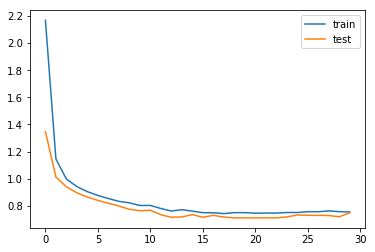

sj_08_minmax2

(646, 568) (278, 568) (646, 1) (278, 1)
y_train [0 0 0 1 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 2 1
 0 0 0 0 0 0 0 0 0 0 1 0 8 0 0 0 3 0 1 1 0 0 6 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 1 2 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 1 7 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 7 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 5 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 9 0 0 0 1 1 0 0 2 1 0 1 0 0 0 0 2 2 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 4 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 2 0 0 

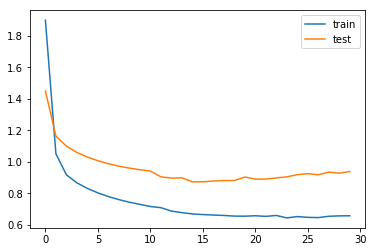

sj_12_minmax2

(644, 852) (276, 852) (644, 1) (276, 1)
y_train [0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 7 8 3 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0
 0 1 0 1 0 0 1 0 0 0 2 0 0 0 0 1 0 1 0 5 0 0 0 1 0 0 1 0 1 0 5 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 2
 1 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 1 1 1 0
 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 2 0 0 2 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 3 0 0 0 0 0 3 0 0 0 0 1 1 1 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 0
 0 0 0 2 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 3 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 7 0 0 0 0 1 2 0 0 0 0 0 0 0 1 1 0 0 2 0 0 0 0
 0 3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 1 0 0 1 0 0 0 6 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 

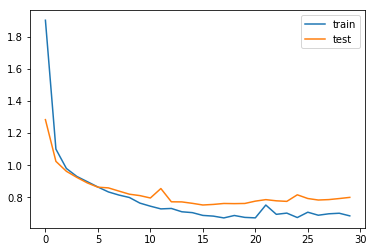

In [384]:
models = dict()
for id in dataset.keys():
    
    print('=================================\n' + id + '\n=================================\n')
    
    myscore = dict()
    X_train_, X_valid_, y_train_, y_valid_ = train_test_split(dataset[id]['X_train'], dataset[id]['y_train'],\
                                                              test_size=.33, random_state=42)
    
    models[id] = GRU_run(dataset[id]['X_train'], dataset[id]['y_train'], timesteps=int(id[3:5]),\
                        reg=0.2, classes=10, epochs=30, batch_size=2, exploring=True)


#Xy_test = Xy_test.reshape(Xy_test.shape[0], 1, Xy_test.shape[1])
#pred_iq = np.argmax(model_iq.predict(Xy_test),axis=1)

## Get test dataset and create predictions

(156, 1)
(260, 1)


In [ ]:
#----------------------------------------------------------------------------------------------------------